<a href="https://colab.research.google.com/github/UEC-MaTa/News_Aggregator/blob/main/%E6%BC%94%E7%BF%92%EF%BC%9AStackOverflow_%E3%81%AE%E8%B3%AA%E5%95%8F%E3%81%AB%E5%AF%BE%E3%81%99%E3%82%8B%E3%83%9E%E3%83%AB%E3%83%81%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [22]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [23]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 演習：StackOverflow の質問に対するマルチクラス分類  
映画レビューのテキスト分類を応用してみる

In [24]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [25]:
print(tf.__version__)

2.12.0


## 演習：StackOverflow の質問に対するマルチクラス分類

このチュートリアルでは、IMDB データセットで二項分類器を最初からトレーニングする方法を示しました。演習として、このノートブックを変更して、[Stack Overflow](http://stackoverflow.com/) のプログラミング質問のタグを予測するマルチクラス分類器をトレーニングできます。

Stack Overflow に投稿された数千のプログラミングに関する質問（たとえば、「Python でディクショナリを値で並べ替える方法」）の本文を含む[データセット](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)が用意されています。それぞれ、1 つのタグ（Python、CSharp、JavaScript、または Java のいずれか）でラベル付けされています。この演習では、質問を入力として受け取り、適切なタグ（この場合は Python）を予測します。

使用するデータセットには、1,700 万件以上の投稿を含む [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) の大規模な StackOverflow パブリックデータセットから抽出された数千の質問が含まれています。

データセットをダウンロードすると、以前に使用した IMDB データセットと同様のディレクトリ構造になっていることがわかります。

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

注意: 分類問題の難易度を上げるために、プログラミングの質問での Python、CSharp、JavaScript、または Java という単語は、*blank* という単語に置き換えられました（多くの質問には、対象の言語が含まれているため）。

この演習を完了するには、、このノートブックを変更してStackOverflow データセットを操作する必要があります。次の変更を行います。

1. ノートブックの上部で、IMDB データセットをダウンロードするコードを、事前に準備されている [Stack Overflow データセット](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)をダウンロードするコードで更新します。Stack Overflow データセットは同様のディレクトリ構造を持っているため、多くの変更を加える必要はありません。

2. 4 つの出力クラスがあるため、モデルの最後のレイヤーを `Dense(4)` に変更します。

3. モデルをコンパイルするときは、損失を  `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` に変更します。これは、各クラスのラベルが整数である場合に、マルチクラス分類問題に使用する正しい損失関数です。(この場合、 0、*1*、*2*、または <em>3</em> のいずれかになります)。さらに、これはマルチクラス分類の問題であるため、メトリックを `metrics=['accuracy']` に変更します (<code>tf.metrics.BinaryAccuracy</code> はバイナリ分類器にのみ使用されます)。

4. 経時的な精度をプロットする場合は、`binary_accuracy` および `val_binary_accuracy`をそれぞれ `accuracy` および `val_accuracy` に変更します。

5. これらの変更が完了すると、マルチクラス分類器をトレーニングできるようになります。

### Stack Overflow データセットをダウンロードして調べる

データセットをダウンロードして抽出してから、ディレクトリ構造を調べてみましょう  
★IMDB データセットをダウンロードから変更

**get_file**  
get_file(fname, origin, untar=False, md5_hash=None, cache_subdir='datasets')  
既にキャッシュされていないならURLからファイルをダウンロードします．

MD5ハッシュ値を渡せば，既にキャッシュされていたとしてもファイルをダウンロードし，同一性を検証します．

引数

fname: ファイル名  
origin: ファイルの置かれているURL  
untar: 真偽値．ファイルを解凍するかどうか  
md5_hash: 同一性検証のためのMD5ハッシュ値  
cache_subdir: キャッシュ先のディレクトリ  
戻り値

ダウンロードされたファイルへのパス

In [26]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))

In [27]:
os.listdir(dataset_dir)

['.config',
 'README.md',
 'stack_overflow_16k.tar.gz',
 'train',
 'test',
 'sample_data']

In [28]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'javascript', 'csharp', 'java']

★stack_overflowフォルダーのファイル構造を確認してみた★
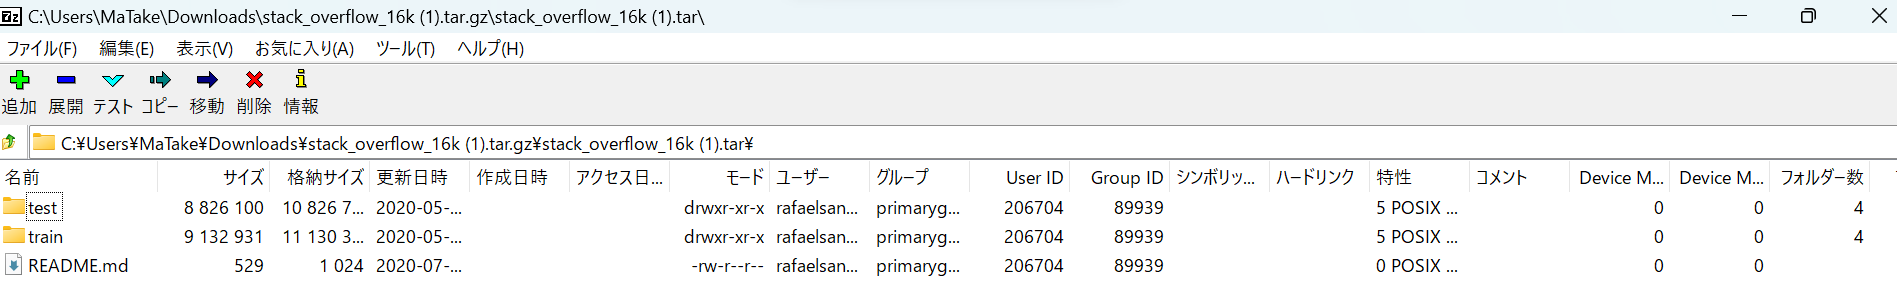

★trainフォルダーのファイル構造を確認してみた★
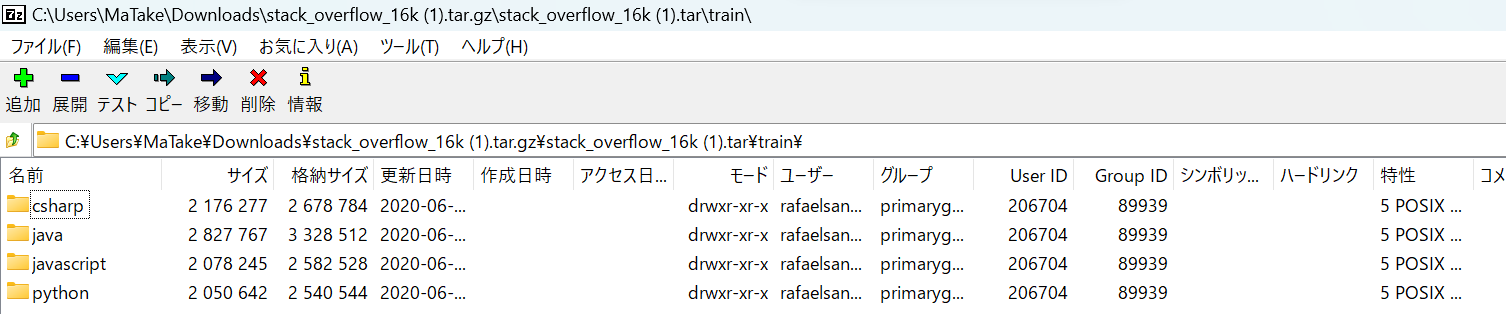

★pythonフォルダーのファイル構造を確認してみた★
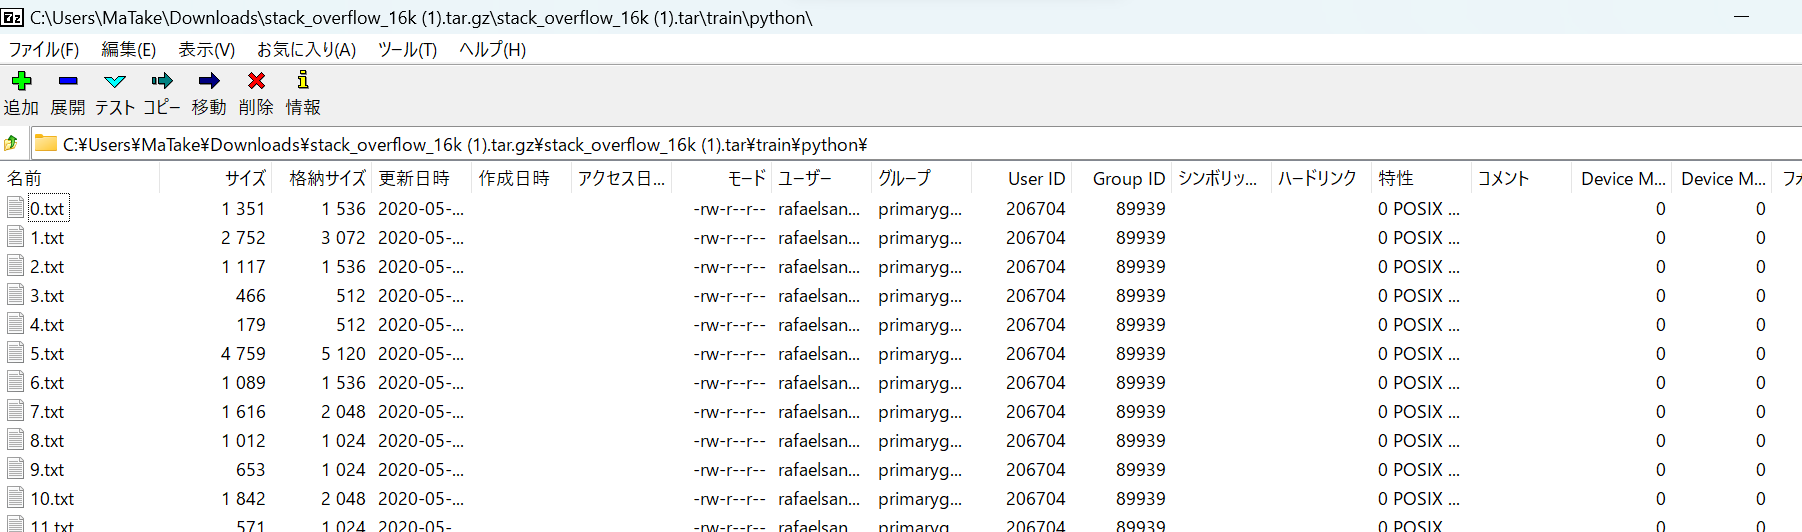

★0.txtを確認してみた★  
"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string = self.string[::-1]    i am prone to add this method..    def check(self):.        reversed = self.reverse().        if self.string == reversed:.            print(""yes"").        else:.            print(""no"")..det = detector(""rise to vote, sir!"").det.eliminator().det.check()...when i add the commented lines, the valid ""yes"" becomes ""no""!"


`train` ディレクトリには多くのテキストファイルが含まれており、それぞれを分類している。それらの 1 つを見てみましょう。

上と同じ結果を確認(python/0.txt)

In [29]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

★Google翻訳を追記してみた★

「同じ名前で戻り値の型が異なる 2 つのメソッドを定義することは合法ですか? 私は典型的な回文文字列を決定するコードを書きました。文字列を返す reverse() メソッドの定義によってこれを行いました。また、 同じメソッドを使用したいと考えていますが、将来のニーズのため、無効な形式になっています。後者をコードに追加すると、有効な出力が無効になります。そこで、問題は、2 つのメソッドを定義するのは合法なのかということです。 同じ名前で戻り値の型が異なりますか?そうでない場合は、void 型メソッドを使用してこのコードを記述する方法を教えてください...class detecter(object):.def __init__(self,string):.self.string = 文字列..禁止 = (' ','!','?','.','-','_','&amp;','%',""#"","","" ).. def eliminator(self):. for item in self.forbidden:. if item in self.string:. self.string = self.string.replace(item,"""").. def reverse(self) :. return self.string[::-1] .. #def reverse(self):. # self.string = self.string[::-1] 私はこのメソッドを追加する傾向があります.. def check(self) :。 反転 = self.reverse()。 self.string == 反転の場合:。 print(""はい"")。 それ以外：。 print(""no"")..det = detecter(""rise to vote, sir!"").det.eliminator().det.check()...コメント行を追加すると、有効な " 「はい」が「いいえ」になります！

### データセットを読み込む

次に、データをディスクから読み込み、トレーニングに適した形式に準備します。これを行うには、便利な [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) ユーティリティを使用します。このユーティリティは、次のようなディレクトリ構造を想定しています。

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

★IMDBデータベースの例★
二項分類用のデータセットを準備するには、ディスクに `class_a` および `class_b`に対応する 2 つのフォルダが必要です。これらは、`aclImdb/train/pos` および `aclImdb/train/neg` にある肯定的および否定的な映画レビューになります。IMDB データセットには追加のフォルダーが含まれているため、このユーティリティを使用する前にそれらを削除します。

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

★StackOverflowの場合★  
４つに分類  
個の事例では削除は不要か

★IMDBデータベースの例★  
次に、`text_dataset_from_directory` ユーティリティを使用して、ラベル付きの `tf.data.Dataset` を作成します。[tf.data](https://www.tensorflow.org/guide/data) は、データを操作するための強力なツールのコレクションです。

機械学習実験を実行するときは、データセットを[トレーニング](https://developers.google.com/machine-learning/glossary#training_set)、[検証](https://developers.google.com/machine-learning/glossary#validation_set)、および、[テスト](https://developers.google.com/machine-learning/glossary#test-set)の 3 つに分割することをお勧めします。

IMDB データセットはすでにトレーニング用とテスト用に分割されていますが、検証セットはありません。以下の `validation_split` 引数を使用して、トレーニングデータの 80:20 分割を使用して検証セットを作成しましょう。

★StackOverflowの場合★  
同じように、80:20に分類

In [30]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


上記のように、トレーニングフォルダには 8,000 の例があり、そのうち 80％ (6,400) をトレーニングに使用します。以下に示すとおり、データセットを `model.fit` に直接渡すことで、モデルをトレーニングできます。`tf.data` を初めて使用する場合は、データセットを繰り返し処理して、次のようにいくつかの例を出力することもできます。

In [31]:
print(raw_train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [32]:
print(list(raw_train_ds.take(1).as_numpy_iterator())) #★

[(array([b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [33]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static vo

レビューには生のテキストが含まれていることに注意してください（句読点や `<br/>` などのような HTML タグが付いていることもあります）。次のセクションでは、これらの処理方法を示します。

ラベルは 0 から 4 です。これらのどれが対応するかを確認するには、データセットの `class_names` プロパティを確認できます。


In [34]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


次に、検証およびテスト用データセットを作成します。トレーニング用セットの残りの 1,600 件のレビューを検証に使用します。

注意:  `validation_split` および `subset` 引数を使用する場合は、必ずランダムシードを指定するか、`shuffle=False` を渡して、検証とトレーニング分割に重複がないようにします。

In [35]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [36]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [37]:
# ★
for text_batch, label_batch in raw_val_ds.take(1):
  for i in range(5):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"indexerror: index 0 is out of bounds for axis 0 with size 0? how to solve it? i am getting this error. indexerror: index 0 is out of bounds for axis 0 with size 0..following is the code:..import pandas as pd.import numpy as np...movie=pd.read_csv(""c:\\users\\bial\\movie.csv"").rating= pd.read_csv(""c:\\users\\bilal\\rating.csv"")...rating.drop([\'timestamp\'], axis=1, inplace= true)..print (rating.shape).print (movie.shape)..def replace_name(x):.    return movie[movie[\'movieid\']==x].title.values[0].rating.movieid= rating.movieid.map(replace_name)....the shape of the movie is : (21061, 3)..the shape of the rating is : (104115, 3)..can you help me how to solve it?"\n'
Label 3
Review b'"how to get math.random() with a unit step i am trying to create a snake game where i have 400x400 pane and the snake moves by 20 at x and y axis. by doing this i have created a grid that has step of 20 at x and y axis. ..i want to randomly spawn a fruit at the pane but i want the width and hei

In [38]:
# ★
for text_batch, label_batch in raw_test_ds.take(1):
  for i in range(5):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"blank how to improve this example? i have a file:..one two three.four five six...i tried this command:..blank -c ""import sys; print \'\'.join(x.replace(""two"", ""xxx"") for x in sys.stdin)""  &lt; file..traceback (most recent call last):.  file ""&lt;string&gt;"", line 1, in &lt;module&gt;.  file ""&lt;string&gt;"", line 1, in &lt;genexpr&gt;.nameerror: global name \'two\' is not defined...i want to get the result:..one xxx three.four five six...how to improve the above example?"\n'
Label 3
Review b'"cost model of the quick-find algorithm i am taking the lesson of algorithm part i in coursera..and this is the problem...in this ppt he said connected need 2 array accesses, and union need 2n+2 array accesses...but in the next ppt, he said union need n array accesses, and find need 1...i am confused about why they are not the same."\n'
Label 1
Review b'"how to programmatically submit a password to a stand alone program in blank i am making a blank application (using microsoft v

### トレーニング用データセットを準備する

次に、便利な `tf.keras.layers.TextVectorization` レイヤーを使用して、データを標準化、トークン化、およびベクトル化します。  

**標準化**とは、テキストを前処理することを指します。通常、句読点や HTML 要素を削除して、データセットを簡素化します。  
**トークン化**とは、文字列をトークンに分割することです (たとえば、空白で分割することにより、文を個々の単語に分割します)。ベクトル化とは、トークンを数値に変換して、ニューラルネットワークに入力できるようにすることです。これらのタスクはすべて、このレイヤーで実行できます。

前述のとおり、レビューには `<br />` のようなさまざまな HTML タグが含まれています。これらのタグは、`TextVectorization` レイヤーのデフォルトの標準化機能によって削除されません (テキストを小文字に変換し、デフォルトで句読点を削除しますが、HTML は削除されません)。  
HTML を削除するカスタム標準化関数を作成します。

注意: [トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（トレーニング/サービングスキューとも呼ばれます）を防ぐには、トレーニング時とテスト時にデータを同じように前処理することが重要です。これを容易にするためには、このチュートリアルの後半で示すように、`TextVectorization` レイヤーをモデル内に直接含めます。

★
**トレーニング サービング スキュー**  
トレーニング サービング スキューは、トレーニング中のパフォーマンスとサービング中のパフォーマンスの差です。この偏りは、以下が原因で発生する可能性があります。

* トレーニング パイプラインとサービス提供パイプラインでのデータの処理方法が異なる。
* トレーニング時とサービング時の間のデータの変化。
* モデルとアルゴリズム間のフィードバック ループ。

Google では、トレーニングとサービング スキューにより、パフォーマンスに悪影響を与える本番環境の機械学習システムが見られました。最善の解決策は、システムやデータの変更によるスキューが気づかないように、明示的にモニタリングすることです。


★  
標準化とか、トークン化については理解できたが、「トレーニング/テストスキュー」は理解できず、以下を得たが、良くわからないので、レクチャーいただきたい。

新保先生アドバイスを追記：  
トレーニングと、テストで前処理が違う、ないし同じ前処理でも違う特徴量を扱うなどの場合にモデルに使用することの問題について。
モデルの中に前処理を取り込むなどの対処


In [39]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #original was '<br />'
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

★  
**tf.strings.regex_replace**  
正規表現 patternにマッチする inputの要素を rewriteで置き換える。

tf.strings.regex_replace(
    input, pattern, rewrite, replace_global=True, name=None
)  
tf.strings.regex_replace("Text with tags.<br /><b>contains html</b>",
                         "<[^>]+>", " ")  
<tf.Tensor: shape=(), dtype=string, numpy=b'Text with tags.  contains html '>  

Args  
**input**	string Tensor,処理するソース文字列。  
**pattern**	文字列またはスカラー文字列 Tensor,使用する正規表現、詳細は https://github.com/google/re2/wiki/Syntax を参照。  
**rewrite**	文字列またはスカラー文字列 Tensor、マッチ置換で使用する値は、バックスラッシュエスケープの数字(\ 1から\ 9)をサポートします。  
**replace_global**	bool, Trueの場合は重複しないすべてのマッチを置換し、それ以外の場合は最初のマッチのみを置換する。  
**name**	操作の名前(オプション)。

**Returns**  
inputと同形状の文字列 Tensorを指定置換した。

次に、`TextVectorization` レイヤーを作成します。このレイヤーを使用して、データを標準化、トークン化、およびベクトル化します。`output_mode` を `int` に設定して、トークンごとに一意の整数インデックスを作成します。

デフォルトの分割関数と、上記で定義したカスタム標準化関数を使用していることに注意してください。また、明示的な最大値 `sequence_length` など、モデルの定数をいくつか定義します。これにより、レイヤーはシーケンスを正確に `sequence_length` 値にパディングまたは切り捨てます。

★  
パディングまたは切り捨て、の意味が良くわからないのでレクチャーいただきたい

新保先生アドバイスを追記：  
パディングは、不足分を０で補う。切り捨ては対象以上を切り捨てること。
sequemth_length=250で、  
単語数が250未満の場合、残りを０で埋める。・・・パディング  
単語数が250を超える場合、それ以外は切り捨てる。・・・切り捨て


In [40]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

**tf.keras.layers.TextVectorization**  https://runebook.dev/ja/docs/tensorflow/keras/layers/textvectorization  
TensorFlowの tf.keras.layers.TextVectorizationレイヤーは、文字列入力(テキストなど)のバッチを数値テンソルのバッチに変換する前処理レイヤーである。文字列を単語にトークン化し、語彙に基づいて各単語を整数にマッピングし、各文字列を整数のシーケンスとして符号化することでこれを実現する。この層は、感情分析や言語モデリングなどの自然言語処理タスクに有用である。

TextVectorizationレイヤーの主な特徴として、カスタムのトークン化と正規化のサポート、設定可能な語彙サイズと最大配列長、入力データに語彙を適応させる機能などがあります。さらに、他のKerasレイヤーと組み合わせて使用することで、幅広い自然言語処理タスクのためのカスタムモデルを構築することができます。

tf.keras.layers.TextVectorization(  
    max_tokens=None,  
    standardize='lower_and_strip_punctuation',  
    split='whitespace',  
    ngrams=None,  
    output_mode='int',  
    output_sequence_length=None,  
    pad_to_max_tokens=False,  
    vocabulary=None,  
    idf_weights=None,  
    sparse=False,  
    ragged=False,  
    **kwargs  
)  

**Args**  
**max_tokens**	このレイヤーのボキャブラリーの最大サイズ。これは、語彙を適合させるとき、または pad_to_max_tokens=Trueを設定するときにのみ指定する必要があります。なお、この語彙にはOOVトークンが1つ含まれているので、有効なトークン数は (max_tokens-1-(1 if output_mode =="int" else 0))です。  
**standardize**	入力テキストに適用する標準化のためのオプションの仕様。値として指定できる。  
None:標準化されていない。
"lower_and_strip_punctuation":テキストは小文字になり、句読点はすべて削除されます。
"lower":文字は小文字になります。
"strip_punctuation" :句読点はすべて削除されます。
呼び出し可能であること。入力は呼び出し可能な関数に渡され、標準化されて返されるはずです。  
**split**	入力テキストを分割するためのオプションの指定。値は以下の通り。
None:割れがない。
"whitespace":空白文字で分割される。
"character":ユニコード文字ごとに分割する。
呼び出し可能。標準化された入力は、呼び出し可能な関数に渡され、その関数は分割されて返される必要があります。  
**ngrams**	分割された入力テキストから作成するngramを指定するオプション。整数を渡すと、その整数までのngramが作成され、整数のタプルを渡すと、そのタプルで指定した値のngramが作成されます。Noneを渡すと、ngramは作成されない。  
**output_mode**	レイヤーの出力に関するオプションの指定。 "int", "multi_hot", "count", "tf_idf"のいずれかを指定し,以下のようにレイヤーを構成する。
"int":分割文字列トークン1個につき1個の整数インデックスを出力する。 output_mode =="int" の場合,0 はマスクされた位置のために予約される.これにより,ボキャブラリーのサイズは max_tokens-1 ではなく max_tokens-2 となる.
"multi_hot":バッチごとに、vocab_sizeまたはmax_tokensサイズのint配列を1つ出力し、そのインデックスにマップされたトークンがバッチアイテムに少なくとも1回は存在するすべての要素に1を含む。
"count": "multi_hot"と同様であるが、int配列にそのインデックスのトークンがバッチアイテムに出現した回数をカウントしている。
"tf_idf": "multi_hot"と同様ですが、TF-IDFアルゴリズムを適用して、各トークンスロットの値を求めます。 "int"出力では、任意の形状の入力と出力がサポートされる。その他の出力モードでは、現在、ランク1入力(分割後はランク2出力)のみがサポートされています。  
**output_sequence_length**	INTモードでのみ有効です。設定された場合、出力は時間次元が正確に output_sequence_lengthの値になるようにパディングまたは切り捨てられ、分割ステップの結果のトークンの数にかかわらず、 (batch_size,output_sequence_length)の形のテンソルになる。デフォルトはNoneです。  
**pad_to_max_tokens**	"multi_hot", "count", "tf_idf" モードでのみ有効です。Trueの場合、語彙のユニークトークンの数がmax_tokensより少なくても、出力はその特徴軸が max_tokensにパディングされ、語彙のサイズに関係なく (batch_size,max_tokens)の形のテンソルになる。デフォルトはFalseです。  
**vocabulary**	オプション。文字列の配列、またはテキストファイルへの文字列パスのどちらかを指定する。配列を渡す場合、文字列の語彙を含むタプル、リスト、1次元numpy配列、または1次元テンソルを渡すことができる。ファイルパスを渡す場合、ファイルには語彙の各用語につき1行が含まれる必要がある。この引数が設定されている場合、レイヤーを adapt()する必要はない。  
**idf_weights**	output_modeが "tf_idf"の場合のみ有効。語彙と同じ長さのタプル、リスト、1次元のnumpy配列、または1次元テンソル。 vocabularyが設定され、 output_modeが "tf_idf"の場合、この引数を与える必要がある。  
**ragged**	ブール値です。 "int"出力モードにのみ適用される。Trueの場合、文字列分割後に各シーケンスが異なる長さになる可能性がある、密な Tensorの代わりに RaggedTensorを返します。デフォルトはFalseです。  
**sparse**	ブール値です。 "multi_hot", "count", "tf_idf" 出力モードのみに適用可能です。Trueの場合、密集した Tensorの代わりに SparseTensorを返します。 デフォルトはFalseです。

次に、`adapt` を呼び出して、前処理レイヤーの状態をデータセットに適合させます。これにより、モデルは文字列から整数へのインデックスを作成します。

★  
このレイヤーの語彙は、構築時に提供されるか、 adapt()を介して学習されなければならない。 このレイヤーが適応されると、データセットを分析し、個々の文字列値の頻度を決定し、それらから語彙を作成することになります。この語彙は、このレイヤーの設定オプションによって、無制限のサイズにすることも、上限を設けることもできる。入力に含まれるユニークな値が最大語彙サイズよりも多い場合、最も頻度の高い用語が語彙の作成に使われることになる。

注意: Adapt を呼び出すときは、トレーニング用データのみを使用することが重要です***（テスト用セットを使用すると情報が漏洩します ・・・この部分は誤訳のよう）***。  
Note: It's important to only use your training data when calling adapt (using the test set would leak information).   

新保先生アドバイスを追記：  
トレーニング用データと、テスト用セットは、データが異なるので、テキストをベクトルに変換する際の対応表そのものが異なる。  
例：I have a pen => ベクトル [1 2 3 4]  トレーニング用データ  
例：I have a pencil => ベクトル [10 5 13 87] でpenは無し テストデータ　使用するとNG。


In [41]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x) #raw_train_dsのうち、text部分のみを取り出すということか
vectorize_layer.adapt(train_text) #このレイヤーの語彙は、構築時に提供されるか、 adapt()を介して学習されなければならない。

このレイヤーを使用して一部のデータを前処理した結果を確認する関数を作成します。

In [42]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [43]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [44]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [45]:
# ★
for i in range(20):
  print(i, " ---> ",vectorize_layer.get_vocabulary()[i])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

0  --->  
1  --->  [UNK]
2  --->  the
3  --->  i
4  --->  to
5  --->  a
6  --->  is
7  --->  in
8  --->  and
9  --->  of
10  --->  if
11  --->  it
12  --->  for
13  --->  this
14  --->  that
15  --->  new
16  --->  blank
17  --->  have
18  --->  string
19  --->  0
Vocabulary size: 10000


モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [46]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [47]:
print(train_ds)
print(val_ds)
print(test_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [60]:
r_batch = next(iter(raw_train_ds)) #★
print(r_batch) #★

batch = next(iter(train_ds)) #★
print("Review", batch)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'"how to change data format in write function in blank? how to change the data format in f.write function? ..loaded_data = 349.00  or 3.00..i want to change data format in write function like %6f in print function. ..ex)  349.00 -> 349.000000 ,   3.00 -> 3.000000..f = open(""test.txt"", \'w\').f.write( str.(loaded_data).zfill(?) )  ...what is the code that performs above function?"\n',
       b'"extract the data along with searched string in blank my file (a table) actually looks like this.  i want to search for a string like ""vonmises"" in the file.  then that is the starting point of what i want to extract.  i have 9 tables like the ones shown below.  now i can search for a ""vonmises"" string in my file, but my question is how to extract the tabular data along with string. ..the code i wrote for searching \'vonmises\' string is:..import re.f_read = open(\'filename\',\'r\').str=\'von mises\'.for line in f_read:    .    m=re.sear

### データセットを構成してパフォーマンスを改善する

以下は、I/O がブロックされないようにするためにデータを読み込むときに使用する必要がある 2 つの重要な方法です。

`.cache()` はデータをディスクから読み込んだ後、データをメモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。これは、多くの小さなファイルを読み込むより効率的です。

`.prefetch()` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、[データパフォーマンスガイド](https://www.tensorflow.org/guide/data_performance)を参照してください。

★  
新保先生アドバイスを追記：  
データパフォーマンスガイドの日本語サイトに問題あり。英語サイトにある図の記載がないなど。内容の理解は、以下の図で確認できる。  
https://docs.google.com/document/d/16cjvqPYmgWidD93Md3NZ0qH_r1r1fta6X5Zt10Cuj3E/edit#

Better performance with the tf.data API  |  TensorFlow Core
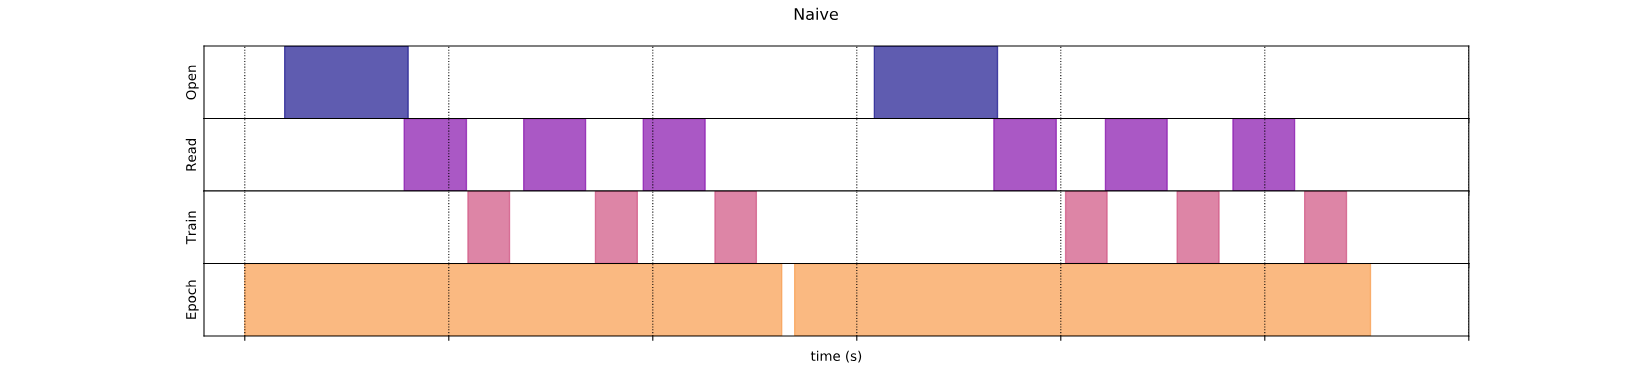
プリフェッチ：RaedとTrainを同時に行う
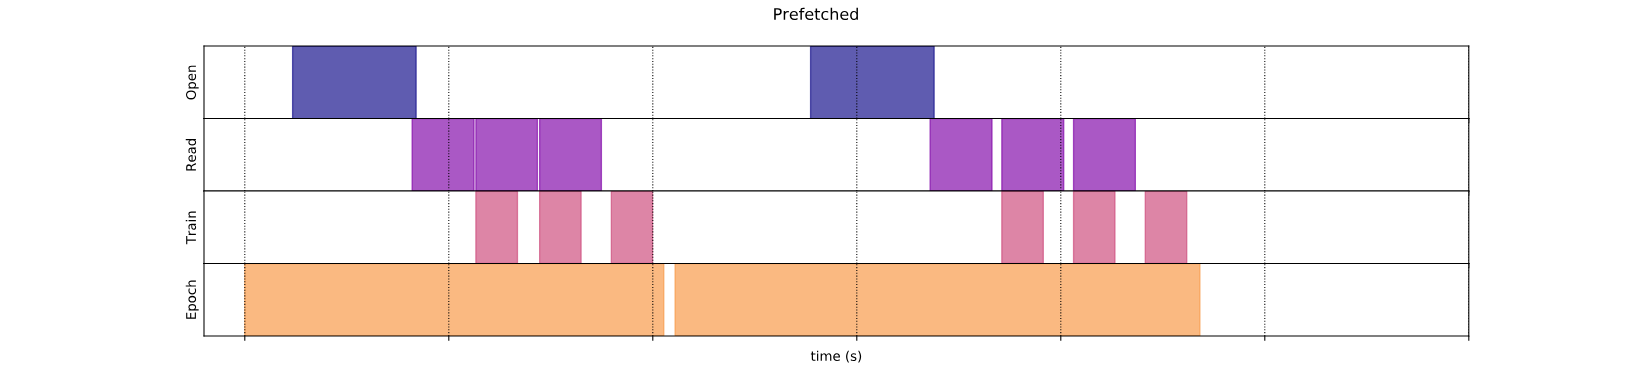
キャッシュ：一度にOpen
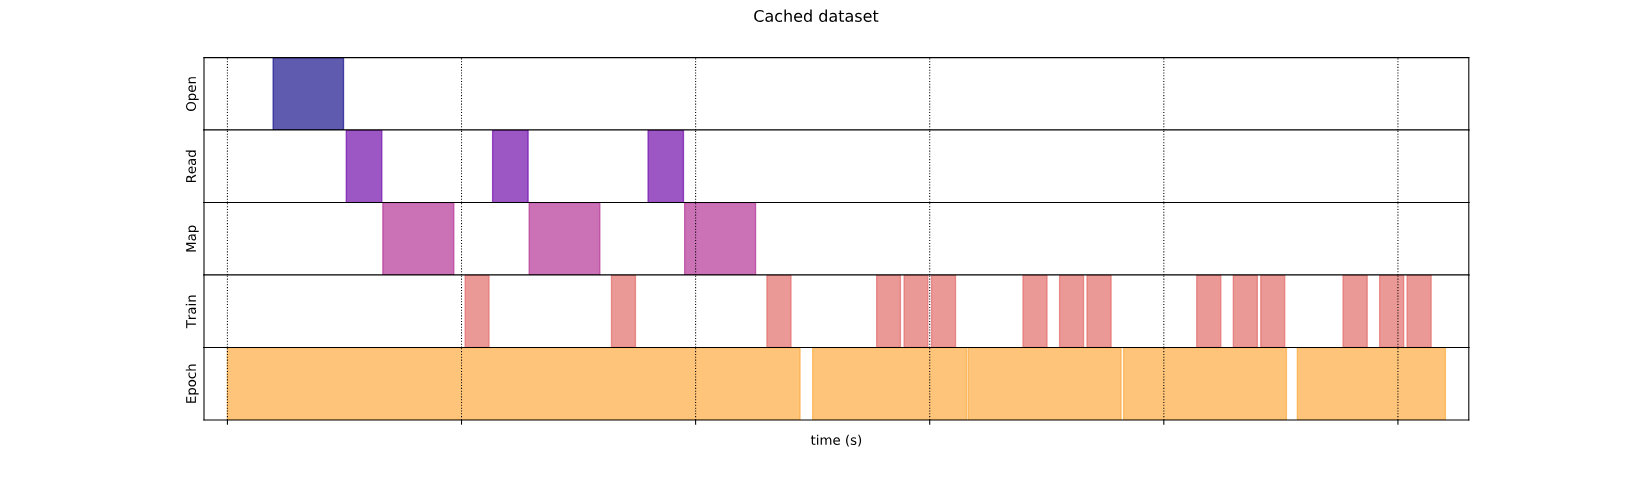


★https://www.tensorflow.org/guide/data_performance?hl=j  
**キャッシング**  
**tf.data.Dataset.cache 変換**は、メモリまたはローカルストレージのいずれかに、データセットをキャッシュすることができるため、各エポック中に一部の操作（ファイルを開いてデータを読み取るなど）が実行されなくなります。

★  
**プリフェッチ**  
プリフェッチは、トレーニングステップの事前処理とモデルの実行に重なって行われます。モデルがトレーニングステップ s を実行する間、入力パイプラインはステップ s+1 のデータを読み取っています。そうすることで、ステップ時間をトレーニングと、データの抽出にかかる時間の最大時間（和とは反対に）に減少させることができます。

tf.data API は、**tf.data.Dataset.prefetch 変換**を提供します。データが生成された時間をデータが消費された時間から切り離すために使用できます。具体的には、この変換は、バックグラウンドのスレッドと内部バッファを使用して、要求される前に入力データセットから要素をプリフェッチします。プリフェッチする要素の数は、単一のトレーニングステップによって消費されるバッチの数と同等（またはそれ以上）である必要があります。この値を手動で調整するか、tf.data.AUTOTUNE に設定することができますが、後者の場合、tf.data ランタイムによって、ランタイム時に動的に値が調整されます。

**プリフェッチ変換**は、「プロデューサ」の作業と「コンシューマ」の作業をオーバーラップする機会があればいつでもオーバーラップさせることに注意してください。

★  
prefetch  
CPUとGPU/TPUでそれぞれ並列に処理を実行させます。  
tf.experiments**.AUTOTUNEで自動的に調節されます。**  
pipeline.png
https://www.tensorflow.org/guide/data_performance

面倒なことは必要ありません。以下の処理を最後に加えるだけです。（本記事ではtrain_dataとtest_dataに対して行う）

dataset = dataset.prefetch(buffer_size=tf.data.experimental**.AUTOTUNE**)

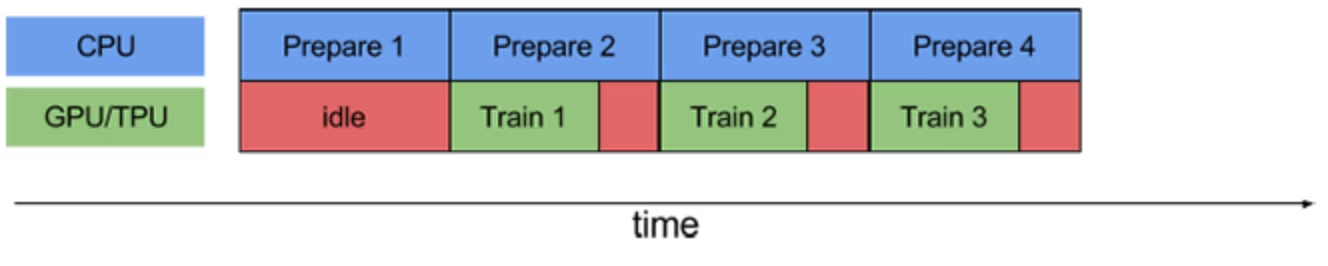

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [65]:
# ★
for text_batch, label_batch in train_ds.take(1):
  for i in range(20): #20個目の文章までとってみた
    print("Review", text_batch.numpy()[i][:10]) #10個目の単語までとってみた
    print("Label", label_batch.numpy()[i],"\n")

Review [1160 2670  272  829   99 1792  418 2670    3  454]
Label 1 

Review [ 116  365  351   44 1068 1452   18   13    6   23]
Label 2 

Review [   6 3099   32 8325    7   16 1975    8   10   50]
Label 1 

Review [  16   30   20  158   44 1081   51    9  298  245]
Label 2 

Review [ 107   16    4 1139   37  184   52   47   16    1]
Label 3 

Review [  16 1769   73  288  488   31   18  195  275   32]
Label 2 

Review [ 550   94    9  427  184 1585    3 1288   13   38]
Label 0 

Review [1391    4  233    1    1    6   28 2790   79   19]
Label 0 

Review [1500    7   16    6   20  158  195  733  661   16]
Label 0 

Review [ 213  231  100 2378 2277  100  530   39   47   16]
Label 3 

Review [  23 1040   86    6   20    1   98   64    8 8792]
Label 1 

Review [   3   69   48    4   70    5 1761    9  596 1225]
Label 3 

Review [ 47   1  38   7 348 158  37   1   9   2]
Label 2 

Review [  52    5   16  969  375    6   15  283 1322 4010]
Label 3 

Review [4541    5 1043    7   16    7   16  

### モデルを作成する

ニューラルネットワークを作成します。

In [66]:
embedding_dim = 16

In [67]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)]) #4 つの出力クラスがあるため、モデルの最後のレイヤーを Dense(4) に変更します。

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

これらのレイヤーは、分類器を構成するため一列に積み重ねられます。

1. 最初のレイヤーは `Embedding` （埋め込み）レイヤーです。このレイヤーは、整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索します。埋め込みベクトルは、モデルのトレーニングの中で学習されます。ベクトル化のために、出力行列には次元が１つ追加されます。その結果、次元は、`(batch, sequence, embedding)` となります。埋め込みの詳細については、[単語埋め込みチュートリアル](https://www.tensorflow.org/text/guide/word_embeddings)を参照してください。
2. 次は、`GlobalAveragePooling1D`（１次元のグローバル平均プーリング）レイヤーです。このレイヤーは、それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返します。この結果、モデルは最も単純な形で、可変長の入力を扱うことができるようになります。
3. この固定長の出力ベクトルは、16 個の非表示ユニットを持つ全結合 (`Dense`) レイヤーに受け渡されます。
4. 最後のレイヤーは、単一の出力ノードと密に接続されています。

★  
**単語の埋め込み**  
単語の埋め込みは、類似した単語が類似したエンコーディングを持つ効率的で密な表現を使用する方法を提供します。重要なのは、このエンコーディングを手動で指定する必要がないことです。埋め込みは、浮動小数点値の密なベクトルです（ベクトルの長さは指定したパラメーターです）。埋め込みの値を手動で指定する代わりに、それらはトレーニング可能なパラメーターです（モデルが密なレイヤーの重みを学習するのと同じ方法で、トレーニング中にモデルによって学習された重み）。大きなデータセットを操作する場合、8次元（小さなデータセットの場合）、最大1024次元の単語の埋め込みがよく見られます。高次元の埋め込みは、単語間のきめ細かい関係をキャプチャできますが、学習するにはより多くのデータが必要です。

新保先生アドバイスを追記：  
整数の場合、例：[1 2 3 4]、１と２は近く、１と４は遠い　のような意味となることもあり。  
これを少数、多次元にすることで近さと遠さの意味とする。  
1024次元・・・学習用に多くの次元とする。ただし、膨大な計算時間。  
計算時間を抑制するために、低い次元で実行（例：8次元）  


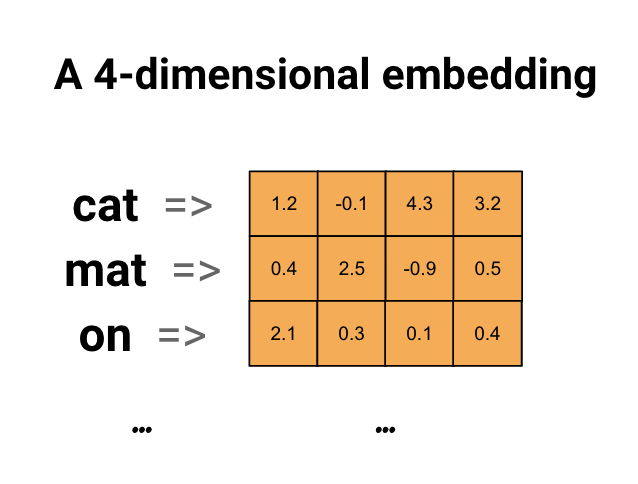

★  
上の図は単語の埋め込みの図です。各単語は、浮動小数点値の4次元ベクトルとして表されます。埋め込みを考える別の方法は、「ルックアップテーブル」です。これらの重みが学習された後、テーブルで対応する密なベクトルを検索することにより、各単語をエンコードできます。

格子  
格子は、データ内の任意の入出力関係を近似することができる**補間ルックアップテーブル**です。構造格子を入力空間にオーバーラップさせ、グリッドの頂点で出力の値を学習します。テストポイントがxの場合、f(x)はxを囲む格子の値から線形補間されます。

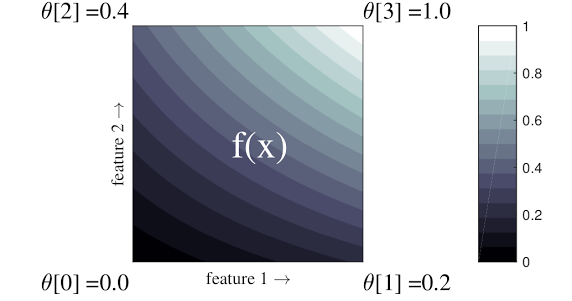

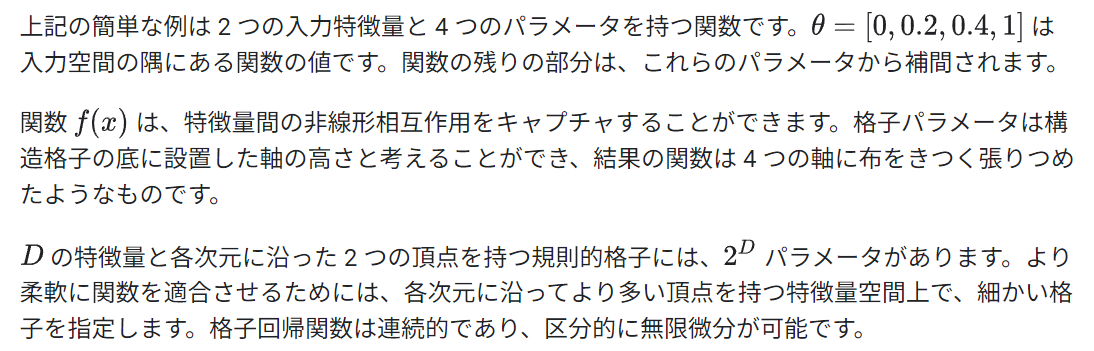

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`losses.BinaryCrossentropy` 損失関数を使用します。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

★  
モデルをコンパイルするときは、損失を tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) に変更します。これは、各クラスのラベルが整数である場合に、マルチクラス分類問題に使用する正しい損失関数です。(この場合、 0、1、2、または 3 のいずれかになります)。さらに、これはマルチクラス分類の問題であるため、メトリックを metrics=['accuracy'] に変更します (tf.metrics.BinaryAccuracy はバイナリ分類器にのみ使用されます)。

In [68]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), #original was BinaryCrossentropy(from_logits=True)
              optimizer='adam',
              metrics='accuracy')  #original was tf.metrics.BinaryAccuracy(threshold=0.0))

### モデルをトレーニングする

`dataset` オブジェクトを fit メソッドに渡すことにより、モデルをトレーニングします。

In [70]:
model.input_shape #★

(None, None)

In [69]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
200/200 [==============================] - 4s 13ms/step - loss: 1.3781 - accuracy: 0.3388 - val_loss: 1.3663 - val_accuracy: 0.4619
Epoch 2/50
200/200 [==============================] - 2s 8ms/step - loss: 1.3486 - accuracy: 0.4686 - val_loss: 1.3269 - val_accuracy: 0.5238
Epoch 3/50
200/200 [==============================] - 2s 11ms/step - loss: 1.2970 - accuracy: 0.5286 - val_loss: 1.2657 - val_accuracy: 0.5744
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 1.2277 - accuracy: 0.5727 - val_loss: 1.1934 - val_accuracy: 0.6156
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 1.1518 - accuracy: 0.6184 - val_loss: 1.1209 - val_accuracy: 0.6594
Epoch 6/50
200/200 [==============================] - 2s 8ms/step - loss: 1.0787 - accuracy: 0.6658 - val_loss: 1.0518 - val_accuracy: 0.6931
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: 1.0119 - accuracy: 0.6956 - val_loss: 0.9910 - val_accuracy: 0.7081
Epoc

### モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 4s 17ms/step - loss: 1.4630 - accuracy: 0.7653
Loss:  1.462955117225647
Accuracy:  0.765250027179718


### 経時的な正解度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の正解度を比較したグラフを作成することができます。

経時的な精度をプロットする場合は、binary_accuracy および val_binary_accuracyをそれぞれ accuracy および val_accuracy に変更します。

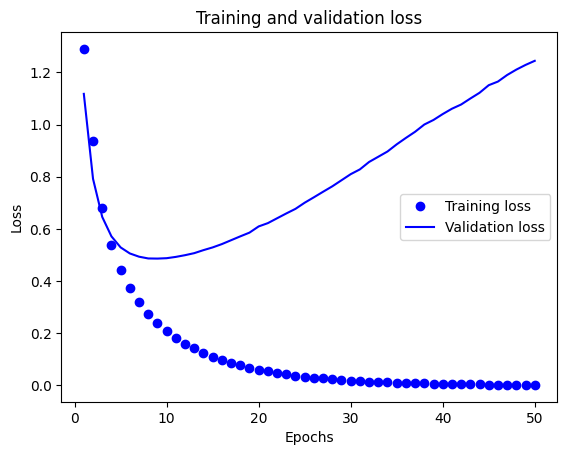

In [ ]:
acc = history_dict['accuracy'] #original was 'binary_accuracy'
val_acc = history_dict['val_accuracy'] #original was 'val_binary_accuracy'
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

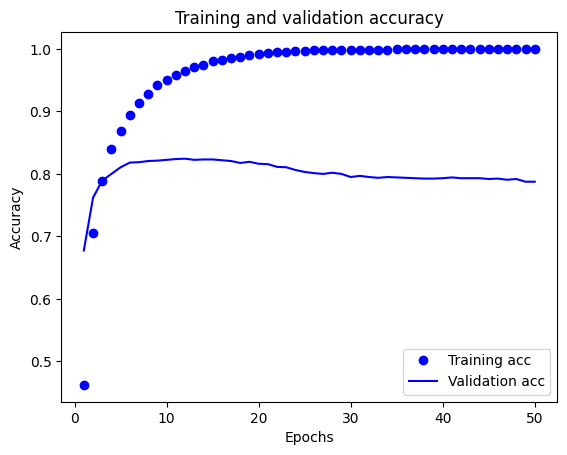

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。

トレーニングの損失がエポックごとに*下降*し、トレーニングの正解度がエポックごとに*上昇*していることに注目してください。これは、勾配下降最適化を使用しているときに見られる現象で、イテレーションごとに希望する量を最小化します。

これは検証の損失と精度には当てはまりません。これらはトレーニング精度の前にピークに達しているようです。これが過適合の例で、モデルが、遭遇したことのないデータよりもトレーニングデータで優れたパフォーマンスを発揮する現象です。この後、モデルは過度に最適化し、テストデータに*一般化*しないトレーニングデータ*特有*の表現を学習します。

この特定のケースでは、検証の正解度が向上しなくなったときにトレーニングを停止することにより、過適合を防ぐことができます。これを行うには、`tf.keras.callbacks.EarlyStopping` コールバックを使用することができます。

★https://qiita.com/yukiB/items/f45f0f71bc9739830002  
**EarlyStopping**  
学習ループに収束判定を付与することができます．監視する値を設定し，それが収束したら自動的にループを抜ける処理になります．

keras.callbacks**.EarlyStopping**(monitor='val_loss', patience=0, verbose=0, mode='auto')  

**arguments**	description  
**monitor**	監視値指定．例えば，monitor='val_loss'  
**patience**	ループの最低数  
**verbose**	保存時に標準出力にコメントを出すか指定．{0, 1}  
**mode**	上限，下限どちらの側に収束した場合に収束判定を出すかの規定．{auto, min, max}  
上記の設定で，以下のように学習ループ途中であっても収束判定がかかり，ループから抜けることができます(下記の表示はverbose=1に設定していた場合)．

## モデルをエクスポートする

上記のコードでは、モデルにテキストをフィードする前に、`TextVectorization` レイヤーをデータセットに適用しました。モデルで生の文字列を処理できるようにする場合 (たとえば、展開を簡素化するため)、モデル内に `TextVectorization` レイヤーを含めることができます。これを行うには、トレーニングしたばかりの重みを使用して新しいモデルを作成します。

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 5s 19ms/step - loss: 1.4630 - accuracy: 0.7653
0.765250027179718


### 新しいデータの推論

新しい例の予測を取得するには、`model.predict()`を呼び出します。

★  
Label 0 corresponds to csharp  
Label 1 corresponds to java  
Label 2 corresponds to javascript  
Label 3 corresponds to python  

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
  #C##事例
  "I am developing a survivor game using the Qt framework with C++ language. Currently, I am implementing in-game saving functionality. My game consists of three main windows: MainWindow, ChooseScene, and Game. The gameplay interface is displayed in the Game window. However, since my windows are implemented as pointers, they contain multiple pointers internally. After saving a game, I clear the memory of the relevant pointers and set them to nullptr. When starting a new game, I allocate memory for them again. The problem I'm facing is that whenever I attempt to start a second round of a new game, the program crashes. I have a MainWindow window, and within its class, there is a pointer object called ChooseScene. Inside this pointer object, there is another pointer object called Game. When I click on Save and Exit, both the Game and ChooseScene windows are closed. At the same time, I use QSettings to save the data and delete these two pointers, which triggers the destructor of each object, deleting other pointer members within them. Finally, the MainWindow window appears. During the debugging process, I added numerous output statements to identify where the program crashes. Eventually, I discovered that the crash occurs right after executing the destructor of the Game object. However, I'm unsure how to resolve this issue. I'm seeking assistance to help identify and resolve this bug. Since I am a beginner, my code is quite lengthy, spanning over 1000 lines. If possible, it would be great to receive suggestions on how to fully implement the in-game saving functionality. Here is my code link:",
  #Java事例
  "I'm writing a ray tracer for which I need to cast rays from the screen into the world. I'm using the inverse of the view-projection-viewport matrix to get back from screen pixel coordinates to world space coordinates. I noticed by accident that two elements of the inverse matrix are always 0, no matter how or where I move, zoom, orbit, or spin the camera. I don't understand the projection matrix deeply enough to know why. This is a hopefully-relevant portion of my Matrix class:",
  #JavaScript事例
  "I was trying to update and delete data using forms with laravel but I cannot send the id using javascript. These are the scripts <script type=text/javascript> $(document).on(click, .edit_modal, function () {var data_id = $(this).data('id'); var data_name = $(this).data(name); $(.form-group #edit_name).val(data_name);});</script><script type=text/javascript>$(document).on(click, .delete_modal, function () {var data_id = $(this).data(id);});</script>And these are the for",
  #Python事例
  "I'm trying to make a small asynchronous application, based on a well-working code from GitHub here. I tried to alter it a little to fit my needs in this way main.py import asyncio from kernel.init import Init async def main(): init = Init() await init.loadSymbols() if __name__ == '__main__': loop = asyncio.new_event_loop() asyncio.run(main()) init.py"
]

export_model.predict(examples)

1/1 [==============================] - 0s 163ms/step


array([[1.0000000e+00, 5.6247762e-03, 1.4214570e-08, 2.3937970e-01],
       [7.2040498e-01, 6.2187579e-02, 1.4914745e-01, 9.7825456e-01],
       [9.9805123e-01, 5.9182366e-06, 9.9972266e-01, 7.6908812e-02],
       [6.0464587e-02, 1.5834800e-04, 3.6910981e-01, 9.9999946e-01]],
      dtype=float32)

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
    "python",
    "java",
    "java script",
    "c"
]

export_model.predict(examples)

1/1 [==============================] - 0s 72ms/step


array([[0.5770613 , 0.6207191 , 0.48232028, 0.2525707 ],
       [0.5731874 , 0.36856958, 0.7113974 , 0.3645449 ],
       [0.46860415, 0.2534624 , 0.8119693 , 0.5873387 ],
       [0.5874888 , 0.54013544, 0.4845986 , 0.33849216]], dtype=float32)

モデル内にテキスト前処理ロジックを含めると、モデルを本番環境にエクスポートして展開を簡素化し、[トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)の可能性を減らすことができます。

TextVectorization レイヤーを適用する場所を選択する際に性能の違いに留意する必要があります。モデルの外部で使用すると、GPU でトレーニングするときに非同期 CPU 処理とデータのバッファリングを行うことができます。したがって、GPU でモデルをトレーニングしている場合は、モデルの開発中に最高のパフォーマンスを得るためにこのオプションを使用し、デプロイの準備ができたらモデル内に TextVectorization レイヤーを含めるように切り替えることをお勧めします。

モデルの保存の詳細については、この[チュートリアル](https://www.tensorflow.org/tutorials/keras/save_and_load)にアクセスしてください。

## 詳細

このチュートリアルでは、最初からテキスト分類を実行する方法を紹介しました。一般的なテキスト分類ワークフローの詳細については、Google Developers の[テキスト分類ガイド](https://developers.google.com/machine-learning/guides/text-classification/)をご覧ください。
